In [10]:
%%capture
!pip install super-gradients==3.2.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [11]:
!pip install roboflow


In [12]:
from super_gradients.training import models

yolo_nas_l = models.get("yolo_nas_l", pretrained_weights="coco")

[2024-05-20 17:25:55] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-05-20 17:25:59] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-05-20 17:26:02] INFO - utils.py - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-05-20 17:26:02] INFO - utils.py - NumExpr defaulting to 8 threads.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2024-05-20 17:26:03] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-05-20 17:26:03] WARNING - export.py - Failed to import pytorch_quantization
[2024-05-20 17:26:03] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-05-20 17:26:03] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2024-05-20 17:26:03] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2024-05-20 17:

In [13]:
!pip install torchinfo
from torchinfo import summary

summary(model=yolo_nas_l,
        input_size=(16, 3, 640, 640),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNAS_L (YoloNAS_L)                                             [16, 3, 640, 640]    [16, 8400, 4]        --                   True
├─NStageBackbone (backbone)                                       [16, 3, 640, 640]    [16, 96, 160, 160]   --                   True
│    └─YoloNASStem (stem)                                         [16, 3, 640, 640]    [16, 48, 320, 320]   --                   True
│    │    └─QARepVGGBlock (conv)                                  [16, 3, 640, 640]    [16, 48, 320, 320]   3,024                True
│    └─YoloNASStage (stage1)                                      [16, 48, 320, 320]   [16, 96, 160, 160]   --                   True
│    │    └─QARepVGGBlock (downsample)                            [16, 48, 320, 320]   [16, 96, 160, 160]   88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

In [14]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

In [15]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="Bfs4O3BiokiFCiKBQwpI")
# project = rf.workspace("bearingfault").project("bearing-defect-1")
# dataset = project.version(10).download("yolov9")
import roboflow

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("bearingfault").project("bearing-defect-1")
dataset = project.version(10).download("yolov9")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Bearing-Defect-1-10 in yolov9::  19%|█▊        | 826/4428 [00:00<00:00, 8255.40it/s]

Extracting Dataset Version Zip to Bearing-Defect-1-10 in yolov9::  88%|████████▊ | 3894/4428 [00:00<00:00, 10294.62it/s]

Start by importing the required modules, which will help you create SuperGradients dataloaders.


In [16]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

You'll need to load your dataset parameters into a dictionary, specifically defining:

- path to the parent directory where your data lives
- the child directory names for training, validation, and test (if you have testing set) images and labels
- class names

In [25]:
dataset_params = {
    'data_dir':'/content/Bearing-Defect-1-10',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['scratch']
}

In [26]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':8
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

[2024-05-20 17:28:26] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 72/72 [00:00<00:00, 7303.09it/s]


### this is transofrm with augmentation. Dont need it.

In [27]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

You can plot a batch of training data with their augmentations applied to see what they look like:

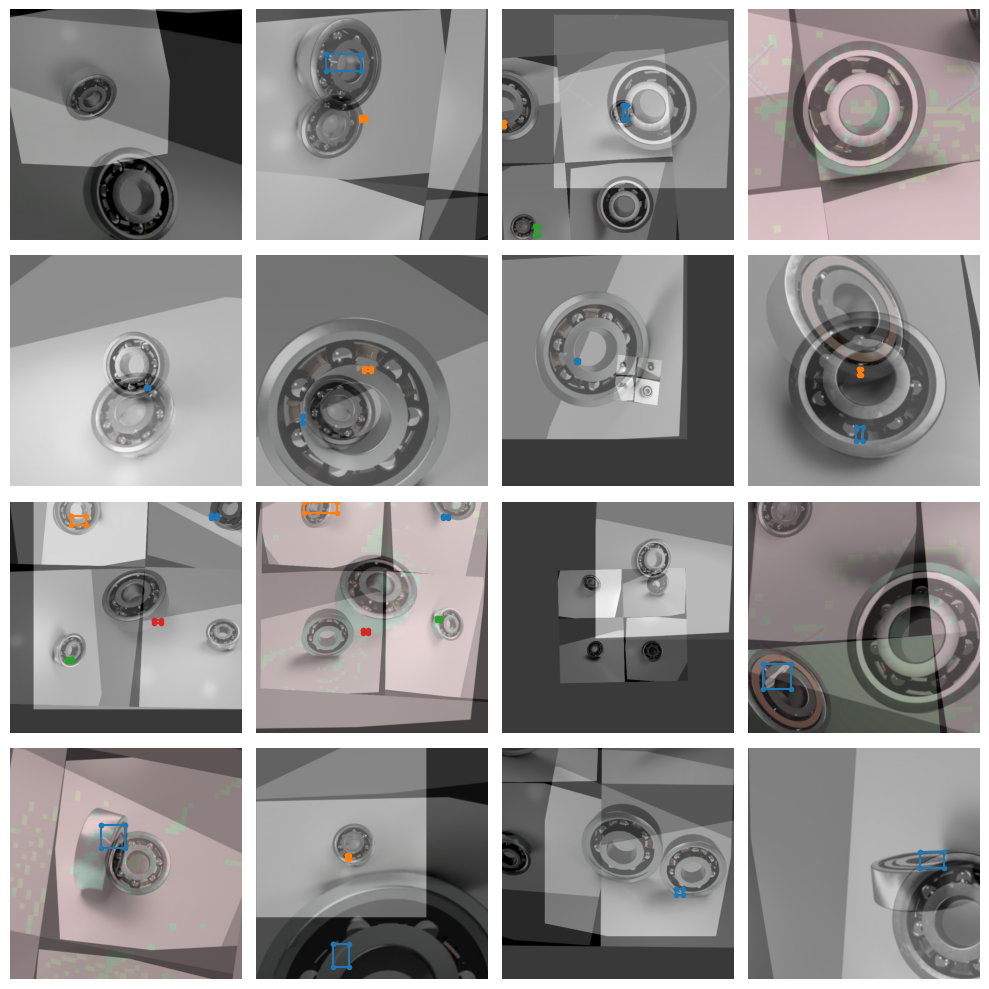

In [28]:
train_data.dataset.plot()

In [29]:
from super_gradients.training import models
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2024-05-20 17:28:35] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-05-20 17:28:36] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


In [30]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    #used default params for NAS architecture
    #updated workers, batchsiz,default checkpoints, pretraining weights
    # ONLY 10 EPOCHS
    "max_epochs": 100,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,

        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,

            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [35]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to checkpoints/my_first_yolonas_run/console_May20_17_58_42.txt


[2024-05-20 17:58:43] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2024-05-20 17:58:45] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 1310       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         81         (len(train_loader))
    - Gradient updates per epoch:   81         (len(train_loader) / batch_accumulate)

[2024-05-20 17:59:25] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2024-05-20 17:59:25] INFO - sg_trainer.py - Best checkpoint overriden: val

In [37]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints/my_first_yolonas_run/ckpt_best.pth")

# best trained model on the test set

In [38]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.25,
                                                   top_k_predictions=10,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.2)
                                                  ))

Testing:  75%|███████▌  | 3/4 [00:01<00:00,  2.65it/s]

{'PPYoloELoss/loss_cls': 1.0093569,
 'PPYoloELoss/loss_iou': 0.36624515,
 'PPYoloELoss/loss_dfl': 1.1171477,
 'PPYoloELoss/loss': 2.4835436,
 'Precision@0.50': 0.4482758641242981,
 'Recall@0.50': 0.3661971688270569,
 'mAP@0.50': 0.2507750689983368,
 'F1@0.50': 0.40310075879096985}

Testing: 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


[2024-05-20 19:23:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


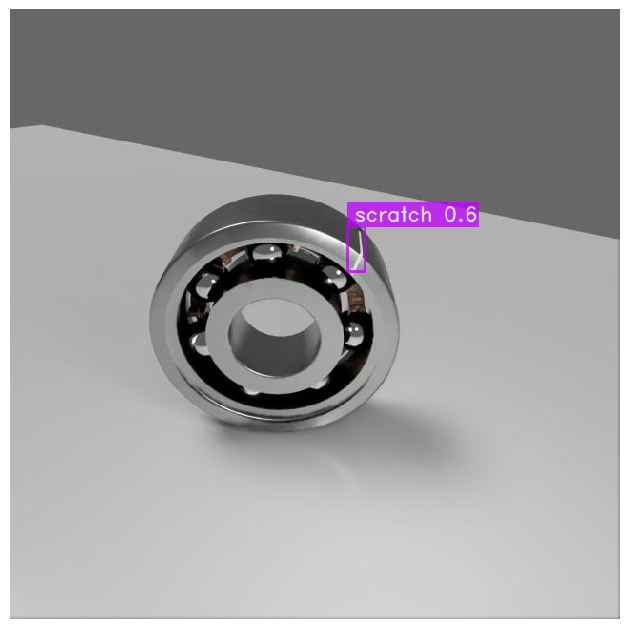

In [39]:
img_url = '/content/Bearing-Defect-1-10/test/images/rgb_0018_png.rf.2e11755220d6f30540da6941db347165.jpg'
best_model.predict(img_url).show()